In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

from sklearn.metrics import accuracy_score,fbeta_score,classification_report
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
nltk.download('stopwords')
stop=stopwords.words("english")

from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer
ss = SnowballStemmer("english")
ps = PorterStemmer()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('spam.csv', sep='\t', names=["label", "message"])
df.shape

(5572, 2)

# Text Preprocessing:

In [3]:
df.head(4)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...


In [4]:
# check class distribution
classes = df['label']
print(classes.value_counts())

ham     4825
spam     747
Name: label, dtype: int64


In [5]:
from sklearn.preprocessing import LabelEncoder

# convert class labels to binary values, 0 = ham and 1 = spam
encoder = LabelEncoder()
Y = encoder.fit_transform(classes)

print(Y[:10])

[0 0 1 0 0 1 0 0 1 1]


Preprocessing the data is an essential step in natural language process. In the following cells, we will convert our class labels to binary values using the LabelEncoder from sklearn, replace email addresses, URLs, phone numbers, and other symbols by using regular expressions, remove stop words, and extract word stems.

In [6]:
# store the SMS message data
text_messages = df['message']
print(text_messages[:10])

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
5    FreeMsg Hey there darling it's been 3 week's n...
6    Even my brother is not like to speak with me. ...
7    As per your request 'Melle Melle (Oru Minnamin...
8    WINNER!! As a valued network customer you have...
9    Had your mobile 11 months or more? U R entitle...
Name: message, dtype: object


In [7]:
# use regular expressions to replace email addresses, URLs, phone numbers, other numbers
# Replace email addresses with 'email'
processed = text_messages.str.replace(r'^.+@[^\.].*\.[a-z]{2,}$',
                                 'emailaddress')

# Replace URLs with 'webaddress'
processed = processed.str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',
                                  'webaddress')

# Replace money symbols with 'moneysymb' (£ can by typed with ALT key + 156)
processed = processed.str.replace(r'£|\$', 'moneysymb')
    
# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
processed = processed.str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',
                                  'phonenumbr')
    
# Replace numbers with 'numbr'
processed = processed.str.replace(r'\d+(\.\d+)?', 'numbr')

In [8]:
# Remove punctuation
processed = processed.str.replace(r'[^\w\d\s]', ' ')

# Replace whitespace between terms with a single space
processed = processed.str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace
processed = processed.str.replace(r'^\s+|\s+?$', '')

In [9]:
# change words to lower case
processed = processed.str.lower()
print(processed)

0       go until jurong point crazy available only in ...
1                                 ok lar joking wif u oni
2       free entry in numbr a wkly comp to win fa cup ...
3             u dun say so early hor u c already then say
4       nah i don t think he goes to usf he lives arou...
                              ...                        
5567    this is the numbrnd time we have tried numbr c...
5568                  will ü b going to esplanade fr home
5569    pity was in mood for that so any other suggest...
5570    the guy did some bitching but i acted like i d...
5571                            rofl its true to its name
Name: message, Length: 5572, dtype: object


In [10]:
from nltk.corpus import stopwords

# remove stop words from text messages

stop_words = set(stopwords.words('english'))

processed = processed.apply(lambda x: ' '.join(
    term for term in x.split() if term not in stop_words))

In [11]:
# Remove word stems using a Porter stemmer
ps = nltk.PorterStemmer()

processed = processed.apply(lambda x: ' '.join(
    ps.stem(term) for term in x.split()))

In [12]:
#Dataframe with cleaned messsage column
frame = { 'label': classes, 'message': processed }
df = pd.DataFrame(frame)

In [13]:
df.head()

,label,message
0,ham,go jurong point crazi avail bugi n great world...
1,ham,ok lar joke wif u oni
2,spam,free entri numbr wkli comp win fa cup final tk...
3,ham,u dun say earli hor u c alreadi say
4,ham,nah think goe usf live around though


In [16]:
#classifying spam and ham messages separately
spam_messages = df[df["label"] == "spam"]["message"]
ham_messages = df[df["label"] == "ham"]["message"]

In [17]:
spam_messages

2       free entri numbr wkli comp win fa cup final tk...
5       freemsg hey darl numbr week word back like fun...
8       winner valu network custom select receivea mon...
9       mobil numbr month u r entitl updat latest colo...
11      six chanc win cash numbr numbr numbr pound txt...
                              ...                        
5537    want explicit sex numbr sec ring numbr cost nu...
5540    ask numbrmobil numbr chatlin inclu free min in...
5547    contract mobil numbr mnth latest motorola noki...
5566    remind onumbr get numbr pound free call credit...
5567    numbrnd time tri numbr contact u u moneysymbnu...
Name: message, Length: 747, dtype: object

In [18]:
ham_messages

0       go jurong point crazi avail bugi n great world...
1                                   ok lar joke wif u oni
3                     u dun say earli hor u c alreadi say
4                    nah think goe usf live around though
6           even brother like speak treat like aid patent
                              ...                        
5565                                              huh lei
5568                              ü b go esplanad fr home
5569                                    piti mood suggest
5570    guy bitch act like interest buy someth els nex...
5571                                       rofl true name
Name: message, Length: 4825, dtype: object

In [19]:
# Tokenizing the spam and ham messages
spam_words = []
ham_words = []

def extractSpamWords(spamMessages):
    global spam_words
    words = [word for word in word_tokenize(spamMessages)]
    spam_words = spam_words + words
    
def extractHamWords(hamMessages):
    global ham_words
    words = [word for word in word_tokenize(hamMessages) ]
    ham_words = ham_words + words

spam_messages.apply(extractSpamWords)
ham_messages.apply(extractHamWords)

0       None
1       None
3       None
4       None
6       None
        ... 
5565    None
5568    None
5569    None
5570    None
5571    None
Name: message, Length: 4825, dtype: object

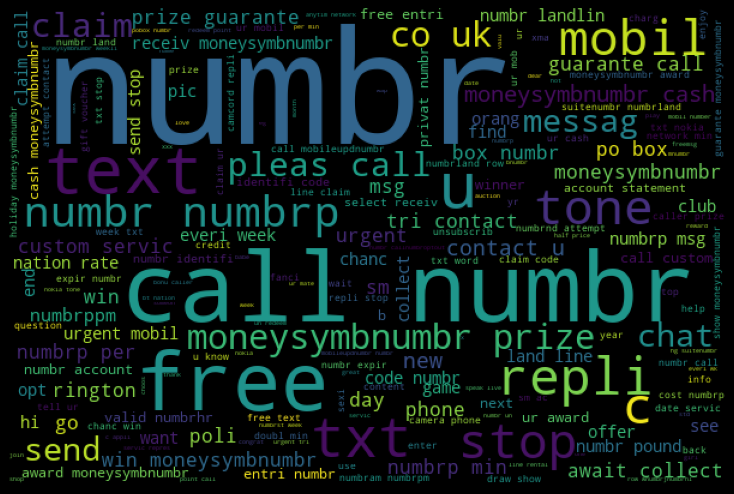

In [20]:
# wordcloud diagram for spam words
spam_wordcloud = WordCloud(width=600, height=400).generate(" ".join(spam_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

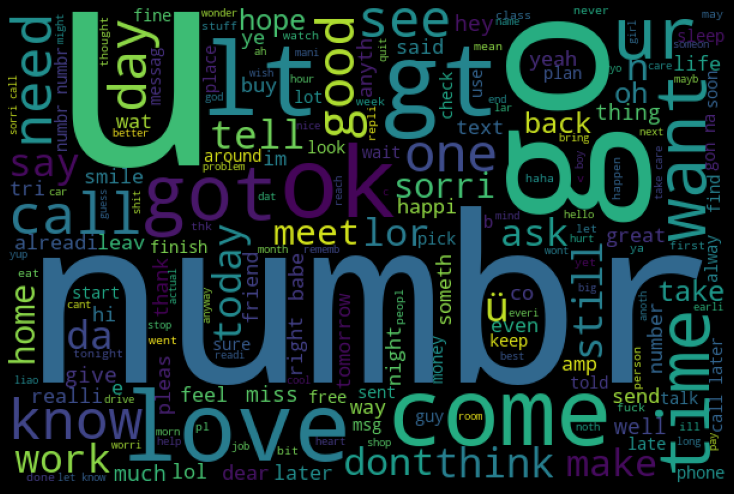

In [21]:
# wordcloud diagram for ham words
ham_wordcloud = WordCloud(width=600, height=400).generate(" ".join(ham_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [22]:
#Change the label column to numerical by assigning  0 to ham and 1 to spam.
def encodeCategory(cat):
    if cat == "spam":
        return 1
    else:
        return 0
        
df["label"] = df["label"].apply(encodeCategory)

# Modeling

In [23]:
X=df["message"]
y=df['label']

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X=cv.fit_transform(X)
print (X.shape)

(5572, 6559)


In [25]:
pickle.dump(cv, open('transform.pkl', 'wb'))

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

# Training model using Naive bayes classifier

from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
model=clf.fit(X_train, y_train)
filename = 'nlp_model.pkl'
pickle.dump(clf, open(filename, 'wb'))

y_pred=model.predict(X_test)

In [27]:
print(clf.score(X_test,y_test))
print(accuracy_score(y_test,y_pred))
print(fbeta_score(y_test,y_pred,beta =0.5))

0.9847533632286996
0.9847533632286996
0.9330143540669857


In [28]:
y_pred

array([0, 1, 0, ..., 0, 1, 0], dtype=int64)

In [29]:
print (classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       955
           1       0.92      0.97      0.95       160

    accuracy                           0.98      1115
   macro avg       0.96      0.98      0.97      1115
weighted avg       0.99      0.98      0.98      1115



Text(0.5, 1.0, 'Confusion Matrix')

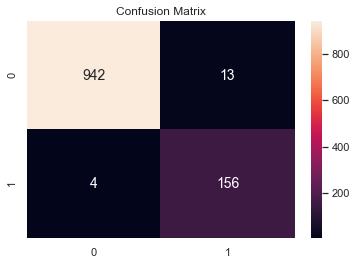

In [30]:
import seaborn as sn
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report as cr

cm1 = cm(y_test, y_pred, labels=[0, 1])
df_cm = pd.DataFrame(cm1, range(2), range(2))
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={'size':14}, fmt='d').set_title('Confusion Matrix')

In [31]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier



lr = LogisticRegression()
nb = MultinomialNB()
knc = KNeighborsClassifier()
svc = SVC(gamma = 'auto')
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier(n_estimators=50)
gbc = GradientBoostingClassifier()
abc = AdaBoostClassifier()


models = {'Logistic Regression':lr, 'Naive Bayes classifier':nb, 'k-nearest neighbors':knc, 
          'Support Vector Machine':svc, 'Decision Tree Classifier':dtc, 
          'Random Forest Classifier':rfc,'Gradient Boosting Classifier':gbc, 'AdaBoost Classifier':abc}

In [32]:
def eval_model(model):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    test_accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['ham', 'spam'], index=['ham','spam'])
    
    return test_accuracy, conf_matrix

In [33]:
test_accuracies = []
confusion_matrices = []
for name, model in models.items():
    test_acc, conf_matrix = eval_model(model) 
    test_accuracies.append(test_acc)
    confusion_matrices.append(conf_matrix)
    print(f'{name} ---> Test accuracy - {test_acc*100:.2f}%')

Logistic Regression ---> Test accuracy - 98.30%
Naive Bayes classifier ---> Test accuracy - 98.48%
k-nearest neighbors ---> Test accuracy - 95.61%
Support Vector Machine ---> Test accuracy - 87.17%
Decision Tree Classifier ---> Test accuracy - 97.94%
Random Forest Classifier ---> Test accuracy - 98.83%
Gradient Boosting Classifier ---> Test accuracy - 98.12%
AdaBoost Classifier ---> Test accuracy - 98.30%


In [34]:
results = pd.DataFrame(test_accuracies, index=list(models.keys()), columns=['test_acc'])
results

,test_acc
Logistic Regression,0.982960
Naive Bayes classifier,0.984753
k-nearest neighbors,0.956054
Support Vector Machine,0.871749
Decision Tree Classifier,0.979372
Random Forest Classifier,0.988341
Gradient Boosting Classifier,0.981166
AdaBoost Classifier,0.982960


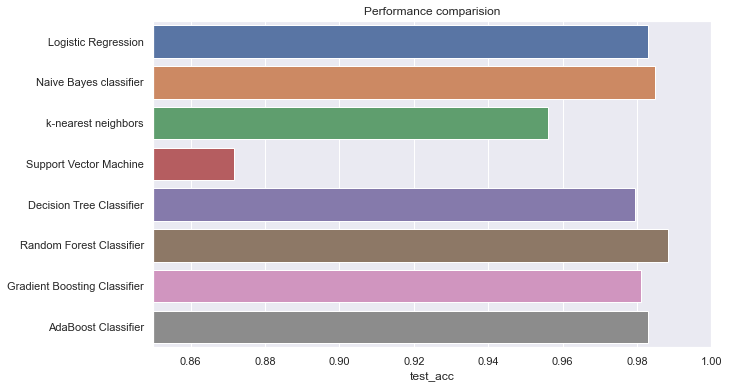

In [35]:
plt.figure(figsize=(10, 6))
sns.barplot(x ='test_acc', y=results.index, data=results)
plt.xlim(0.85, 1.0)
plt.title('Performance comparision')
plt.show()

In [36]:
plot_confusion_matrices(models, confusion_matrices)

NameError: name 'plot_confusion_matrices' is not defined